## Install libraries

In [ ]:
!pip install laspy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for laspy: filename=laspy-2.5.3-py3-none-any.whl size=84500 sha256=fda45df27b11ffc781ae65cc4602be31fa540d4c63adb1e827d637231a423905
  Stored in directory: /root/.cache/pip/wheels/b8/d3/3c/46a6d5ee3daddc13f662b688640db57b53147cb4add4205511
Successfully built laspy


In [ ]:
import numpy as np
import laspy
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from glob import glob

The x, y, and z coordinates from the las object are extracted using las.x, las.y, and las.z.
The coordinates are vertically stacked using np.vstack to create a 2D array where each row represents a point, and each column represents a coordinate (x, y, z).
The resulting array is transposed using .transpose() to ensure that each row corresponds to a point's (x, y, z) coordinates.

In [ ]:
def read_las_file(file_path):
    with laspy.open(file_path) as file:
        las = file.read()
        points = np.vstack((las.x, las.y, las.z)).transpose()
    return points

The function iterates over each class label, locates LAS files corresponding to that label within the specified root directory, and reads the point cloud data from those LAS files using a function called read_las_file. It then performs subsampling or padding to ensure that each point cloud contains the specified number of points (num_points).

The subsampling is done by randomly selecting points if the number of points in the original data exceeds the desired number (num_points). If the number of points is less than num_points, additional points are randomly chosen with replacement to fill the gap. The point clouds and their corresponding class labels are collected during this process.

Finally, the class labels are converted to categorical format.

In [ ]:
def preprocess_data(root_dir, class_labels, num_points=1024):
    point_clouds = []
    labels = []
    file_name = []
    for idx, label in enumerate(class_labels):
        las_files = glob(f"{root_dir}/{label}/*.las")
        for file in las_files:
            points = read_las_file(file)
            # Subsample or pad points to `num_points`
            if len(points) > num_points:
                indices = np.random.choice(len(points), num_points, replace=False)
                points = points[indices, :]
            elif len(points) < num_points:
                additional_indices = np.random.choice(len(points), num_points - len(points), replace=True)
                additional_points = points[additional_indices, :]
                points = np.vstack((points, additional_points))
            point_clouds.append(points)
            labels.append(idx)
            file_name.append(file.replace('/content/drive/My Drive/segments/','') )
    labels = to_categorical(labels)
    return np.array(point_clouds), labels, file_name

In [ ]:
from google.colab import drive
drive.mount(r"/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

# Specify the path to the folder you're looking for
folder_path = '/content/drive/My Drive/segments'

# Check if the folder exists
if os.path.exists(folder_path):
    print("Folder exists.")
else:
    print("Folder does not exist.")


Folder exists.


The classes are "cars" (0), "trees" (1), "house" (2), and "road" (3).

The function then iterates over each class label and checks for the existence of the corresponding folder. For each class folder found, it looks for LAS files and reads them. The x, y, and z coordinates from the LAS files are stacked vertically to form a matrix representing the points in 3D space.

Finally, the function returns the list of point clouds and labels.

In [ ]:
def load_las_files_from_drive(base_path):
    point_clouds = []
    labels = []
    class_labels = {"cars": 0, "trees": 1, "house": 2, "road": 3}
    for class_folder, class_label in class_labels.items():
        full_path = os.path.join(base_path, class_folder)
        if os.path.exists(full_path):
            for file in os.listdir(full_path):
                if file.endswith(".las"):
                    las_file_path = os.path.join(full_path, file)
                    las = laspy.read(las_file_path)
                    points = np.vstack((las.x, las.y, las.z)).transpose()
                    point_clouds.append(points)
                    labels.append(class_label)
        else:
            print(f"Folder {full_path} not found")
    return point_clouds, labels

In [ ]:

# Example usage
base_path = "/content/drive/My Drive/segments"

In [ ]:
# Define the root directory of your dataset
root_dir ='/content/drive/My Drive/segments'  # Update this with the actual path

## Train-test split

In [ ]:
class_labels = ['cars', 'house', 'road', 'trees']
point_clouds, labels, file_name = preprocess_data(root_dir, class_labels)
# file_name is just used for detecting which files are in the test set for visualizing purposes later
X_train, X_test, y_train, y_test, file_name_train, file_name_test = train_test_split(point_clouds, labels, file_name, test_size=0.2, random_state=42)


In [ ]:
file_name_test

['cars/car 1.las',
 'cars/car6.las',
 'house/house 20.las',
 'house/house finished.las',
 'house/house 23.las',
 'trees/trees+2.las',
 'house/house 17.las',
 'house/house 21.las',
 'trees/tree 6.las',
 'house/house 5.las',
 'trees/tree 8.las',
 'cars/car 4.las']

## Model-1

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, BatchNormalization, MaxPooling1D, Flatten

def create_pointnet(num_classes):
    model = tf.keras.Sequential([
        Conv1D(32, 1, activation="relu", input_shape=(1024, 3)),
        BatchNormalization(),
        Conv1D(64, 1, activation="relu"),
        BatchNormalization(),
        MaxPooling1D(pool_size=64),
        Flatten(),
        Dense(32, activation="relu"),
        BatchNormalization(),
        Dense(32, activation="relu"),
        BatchNormalization(),
        Dense(num_classes, activation="softmax")
    ])
    return model

model = create_pointnet(len(class_labels))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# history = model.fit(X_train_t, y_train, epochs=20, batch_size=32, validation_data=(X_test_t, y_test))
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
2/2 [==============================] - 3s 249ms/step - loss: 2.0006 - accuracy: 0.0667 - val_loss: 6784.7495 - val_accuracy: 0.0000e+00
Epoch 2/20
2/2 [==============================] - 0s 33ms/step - loss: 1.5010 - accuracy: 0.2222 - val_loss: 5807.4800 - val_accuracy: 0.5000
Epoch 3/20
2/2 [==============================] - 0s 36ms/step - loss: 1.3546 - accuracy: 0.3556 - val_loss: 5629.9297 - val_accuracy: 0.5000
Epoch 4/20
2/2 [==============================] - 0s 32ms/step - loss: 1.3835 - accuracy: 0.4667 - val_loss: 6399.3550 - val_accuracy: 0.5000
Epoch 5/20
2/2 [==============================] - 0s 33ms/step - loss: 1.2258 - accuracy: 0.4667 - val_loss: 7845.3843 - val_accuracy: 0.5000
Epoch 6/20
2/2 [==============================] - 0s 32ms/step - loss: 1.2173 - accuracy: 0.4667 - val_loss: 8480.4814 - val_accuracy: 0.5000
Epoch 7/20
2/2 [==============================] - 0s 33ms/step - loss: 1.1385 - accuracy: 0.5556 - val_loss: 8970.4717 - val_accuracy: 0.5000
E

In [ ]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_44 (Conv1D)          (None, 1024, 32)          128       
                                                                 
 batch_normalization_92 (Ba  (None, 1024, 32)          128       
 tchNormalization)                                               
                                                                 
 conv1d_45 (Conv1D)          (None, 1024, 64)          2112      
                                                                 
 batch_normalization_93 (Ba  (None, 1024, 64)          256       
 tchNormalization)                                               
                                                                 
 max_pooling1d_22 (MaxPooli  (None, 16, 64)            0         
 ng1D)                                                           
                                                     

Finding the index of one of the wrong and correct classifications to visualize

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

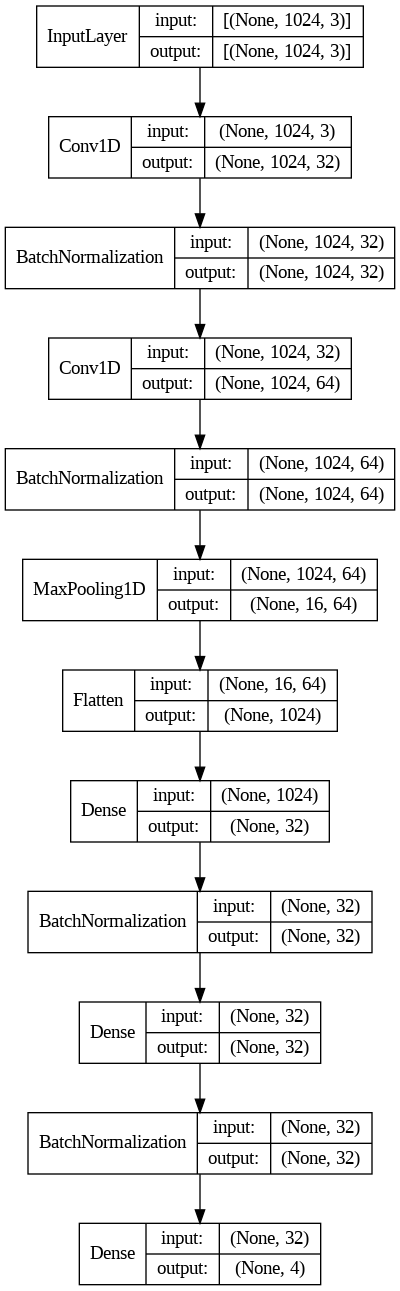

In [ ]:
import keras
from keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=False)

In [ ]:
model.evaluate(X_test, y_test)
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict labels for the test set
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_true_labels = np.argmax(y_test, axis=1)

# Generate classification report
#print(classification_report(y_true_labels, y_pred_labels, target_names=class_labels))

1/1 [==============================] - 0s 155ms/step


In [ ]:
print(file_name_test)
print(y_pred_labels)
print(y_true_labels)

['cars/car 1.las', 'cars/car6.las', 'house/house 20.las', 'house/house finished.las', 'house/house 23.las', 'trees/trees+2.las', 'house/house 17.las', 'house/house 21.las', 'trees/tree 6.las', 'house/house 5.las', 'trees/tree 8.las', 'cars/car 4.las']
[1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 1 1 1 3 1 1 3 1 3 0]


## Model-2

In [ ]:
X_train_t = np.expand_dims(X_train, axis=3)

In [ ]:
X_test_t = np.expand_dims(X_test, axis=3)

An additional dimention is added to train data to make it suitable for Conv2D layers

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, BatchNormalization, MaxPooling2D, Flatten

def create_pointnet(num_classes):
    model = tf.keras.Sequential([
        Conv2D(16, 1, activation="relu", input_shape=(1024, 3, 1)),
        BatchNormalization(),
        Conv2D(32, 1, activation="relu"),
        BatchNormalization(),
        # MaxPooling2D(),
        Flatten(),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Dense(num_classes, activation="softmax")
    ])
    return model

model = create_pointnet(len(class_labels))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train_t, y_train, epochs=20, batch_size=32, validation_data=(X_test_t, y_test))


Epoch 1/20
2/2 [==============================] - 9s 563ms/step - loss: 1.5024 - accuracy: 0.3111 - val_loss: 159.6631 - val_accuracy: 0.2500
Epoch 2/20
2/2 [==============================] - 0s 51ms/step - loss: 1.3270 - accuracy: 0.4667 - val_loss: 139.5040 - val_accuracy: 0.2500
Epoch 3/20
2/2 [==============================] - 0s 33ms/step - loss: 1.2594 - accuracy: 0.4222 - val_loss: 136.8334 - val_accuracy: 0.2500
Epoch 4/20
2/2 [==============================] - 0s 33ms/step - loss: 1.2435 - accuracy: 0.5111 - val_loss: 134.5772 - val_accuracy: 0.2500
Epoch 5/20
2/2 [==============================] - 0s 34ms/step - loss: 1.2896 - accuracy: 0.4444 - val_loss: 123.9956 - val_accuracy: 0.2500
Epoch 6/20
2/2 [==============================] - 0s 36ms/step - loss: 1.3268 - accuracy: 0.3111 - val_loss: 124.1243 - val_accuracy: 0.2500
Epoch 7/20
2/2 [==============================] - 0s 33ms/step - loss: 1.1997 - accuracy: 0.4667 - val_loss: 127.6839 - val_accuracy: 0.2500
Epoch 8/20
2

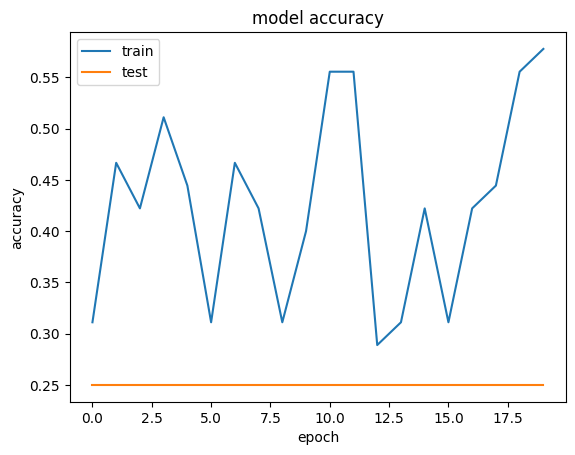

In [ ]:
# summarize history for accuracy
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

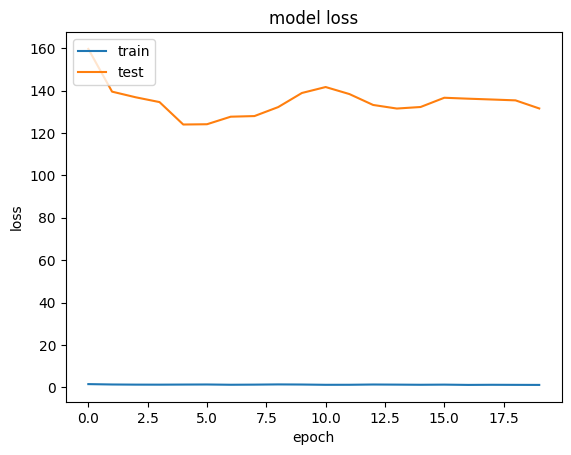

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()